In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2

In [4]:
os.listdir('/kaggle/input/lung-cancer-ct/LUNG CANCER')

['valid', 'test', 'train']

In [5]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    images={}
    count=0

    for i in range(len(classes)):
        x=""
        if i==0:
          x="Lung Cancer"
        elif i==1:
          x="Normal"
        imgs=os.listdir(os.path.join(data_path, x))
        images[i]=imgs
        count+=len(imgs)

    for k, v in images.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return images

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        x=""
        if k==0:
          x="Lung Cancer"
        elif k==1:
          x="Normal"
        for i in range(5):
            img_path=os.path.join(data_path, x, v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"{x}")
        plt.show()

In [6]:
class_names=['Lung Cancer', 'Normal']

In [7]:
base_dir="/kaggle/input/lung-cancer-ct/LUNG CANCER"
train_path=os.path.join(base_dir, 'train')
valid_path=os.path.join(base_dir, 'valid')
test_path=os.path.join(base_dir, 'test')

In [8]:
train_data=get_classes(train_path, class_names, 'Train')
valid_data=get_classes(valid_path, class_names, 'Valid')
test_data=get_classes(test_path, class_names, 'Test')

----Train----
Grade 0-Lung Cancer: 1276 images, 51.66%
Grade 1-Normal: 1194 images, 48.34%
----Valid----
Grade 0-Lung Cancer: 144 images, 52.17%
Grade 1-Normal: 132 images, 47.83%
----Test----
Grade 0-Lung Cancer: 144 images, 52.17%
Grade 1-Normal: 132 images, 47.83%


Train data-Lung Cancer


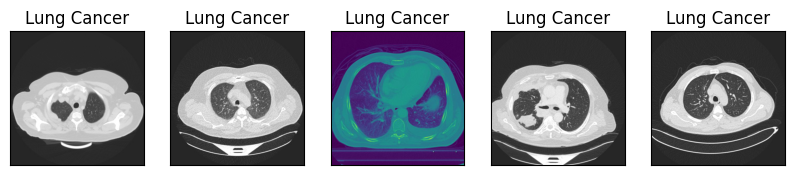

Train data-Normal


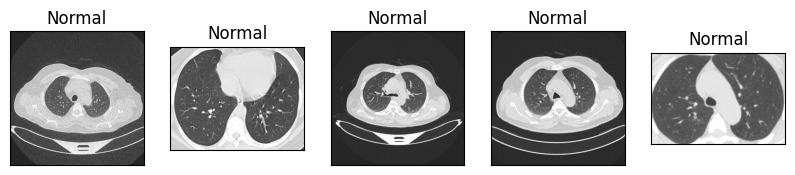

In [9]:
plot_classes(train_data, train_path, class_names, 'Train data')

In [10]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [11]:
model_name="ResNet50"

target_size=(224, 224)
epochs=10
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [12]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

Found 2470 images belonging to 2 classes.


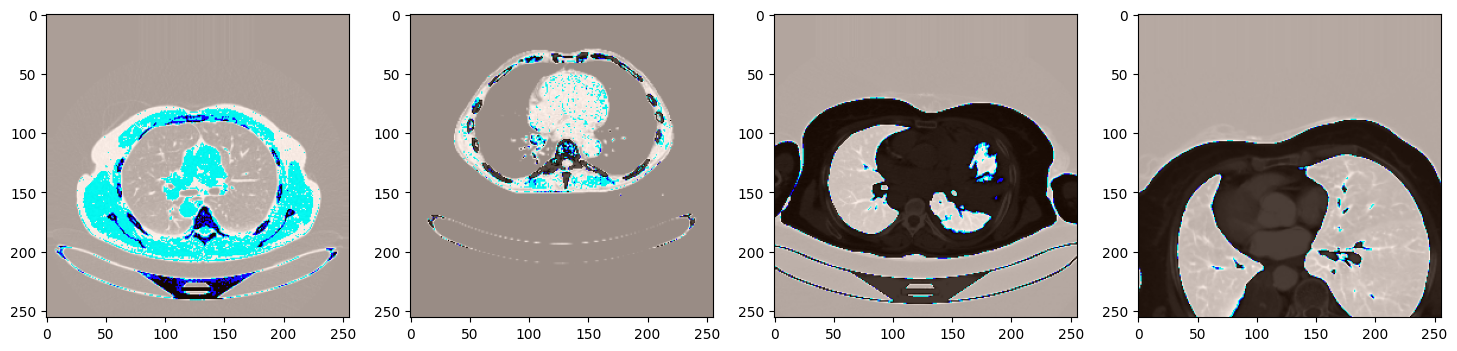

In [17]:
imagegen=aug_datagen.flow_from_directory(train_path, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype('uint8'))
plt.show()

In [18]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 2470 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [19]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [20]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 1276, 1: 1194}
{0: 0.9678683385579937, 1: 1.0343383584589614}


In [21]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [22]:
model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
m=model.output

In [24]:
m = tf.keras.layers.GlobalAveragePooling2D()(m)
m = tf.keras.layers.Dropout(0.2)(m)

In [25]:
predictions = tf.keras.layers.Dense(2, activation='softmax')(m)

In [26]:
model_ft = tf.keras.models.Model(inputs=model.input, outputs=predictions)
model_ft.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [27]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [28]:
start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728227692.539892     155 service.cc:145] XLA service 0x7f91b0005920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728227692.539961     155 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728227692.539967     155 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728227722.288462     155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1728227722.332

68/78 ━━━━━━━━━━━━━━━━━━━━ 9s 959ms/step - accuracy: 0.8034 - loss: 0.7231

I0000 00:00:1728227786.709084     155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 20 bytes spill stores, 20 bytes spill loads



78/78 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8104 - loss: 0.7010 - val_accuracy: 0.7464 - val_loss: 3.3505
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.8860 - loss: 0.3160 - val_accuracy: 0.8442 - val_loss: 1.0791
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 510ms/step - accuracy: 0.9077 - loss: 0.2329 - val_accuracy: 0.8080 - val_loss: 2.0124
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 44s 517ms/step - accuracy: 0.8881 - loss: 0.2721 - val_accuracy: 0.5217 - val_loss: 2.9341
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 508ms/step - accuracy: 0.9235 - loss: 0.1885 - val_accuracy: 0.7536 - val_loss: 1.3901
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 508ms/step - accuracy: 0.9237 - loss: 0.1796 - val_accuracy: 0.3949 - val_loss: 1.9737
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 44s 515ms/step - accuracy: 0.9288 - loss: 0.1551 - val_accuracy: 0.6377 - val_loss: 4.1428
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.9340 - loss: 0.1472 - val_accuracy: 0.5217 

In [29]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model ResNet50 fine tuning executed in 8.93 minutes


In [30]:
model.save('/kaggle/working/ResNet50.h5')

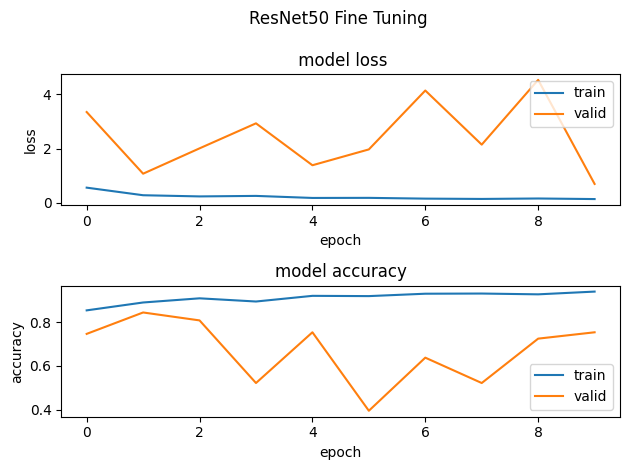

In [31]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [32]:
get_evaluate(valid_generator, "Valid", model_ft)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.7515 - loss: 0.6844
Valid loss:  0.70
Valid accuracy:  0.75


In [33]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 600ms/step
Accuracy Score - ResNet50:  0.75
Balanced Accuracy Score - ResNet50:  0.75


              precision    recall  f1-score   support

           0       0.76      0.78      0.77       144
           1       0.75      0.73      0.74       132

    accuracy                           0.75       276
   macro avg       0.75      0.75      0.75       276
weighted avg       0.75      0.75      0.75       276



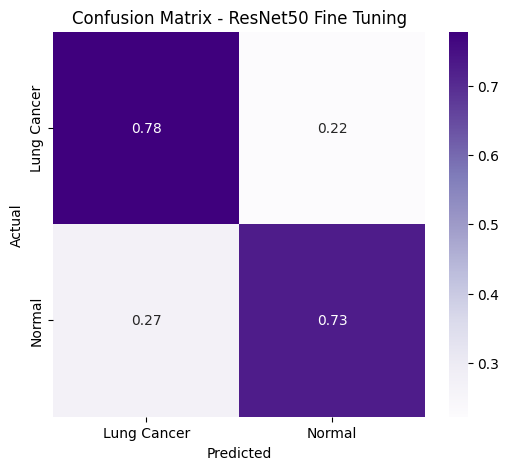

In [34]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [35]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 276 images belonging to 2 classes.


In [36]:
ResNet50 = model_ft

In [37]:
predictions_resnet50 = ResNet50.predict(test_generator)
score_resnet50 = ResNet50.evaluate(test_generator, verbose=1)
print('Test loss:', score_resnet50[0])
print('Test acc:', score_resnet50[1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 573ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8736 - loss: 0.3111
Test loss: 0.30321186780929565
Test acc: 0.8768116235733032


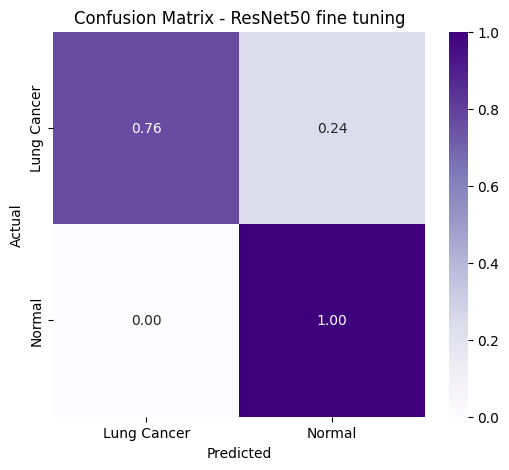

In [38]:
compute_confusion_matrix(
    test_generator,
    predictions_resnet50,
    class_names,
    f"{model_name} fine tuning",
)

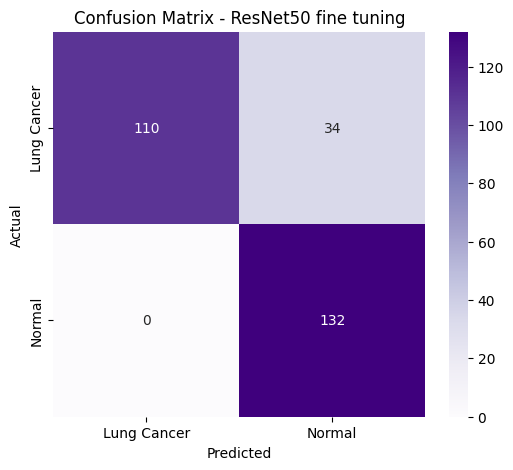

In [39]:
def count_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("int")
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".0f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)
    
count_confusion_matrix(
    test_generator,
    predictions_resnet50,
    class_names,
    f"{model_name} fine tuning",
)

In [40]:
results = get_predict(test_generator, ResNet50)

get_metrics(
    test_generator.labels,
    y_pred=np.argmax(results, axis=1),
    model_name=model_name,
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step
Accuracy Score - ResNet50:  0.88
Balanced Accuracy Score - ResNet50:  0.88


              precision    recall  f1-score   support

           0       1.00      0.76      0.87       144
           1       0.80      1.00      0.89       132

    accuracy                           0.88       276
   macro avg       0.90      0.88      0.88       276
weighted avg       0.90      0.88      0.88       276

